In [1]:
import os
import h5py
import json
import keras
import random 
import imageio
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

Using TensorFlow backend.


In [ ]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

In [ ]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
Data.head()

In [ ]:
Data.dtypes

In [ ]:
Data["Number of dates since posted"]=Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

MaxT=max(Data["Project Posted Date"])
MinT=min(Data["Project Posted Date"])

In [ ]:
print("MaxT :",MaxT,"\t\t","MinT :",MinT)

In [ ]:
T= datetime.date(2013, 1, 1)+timedelta(days=14)


In [ ]:
T

In [ ]:
Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch","Project Cost"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category"]

In [ ]:
#===============================================================================================
#                                       LogisticRegression
#===============================================================================================

LR_clf = LogisticRegression(random_state=9)

T_current=MinT-timedelta(days=28)+timedelta(days=120)    
T_period=3 #timedelta(days=28)    
acc=[]
T=[]
pr=[]
re=[]

accT=[]
prT=[]
reT=[]
sub_var=list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))

Model_variables=Model_variables_con.copy()
for i in sub_var: print(i,i in Data.columns)
sub_Data =Data.loc[:,sub_var]

while (T_current<MaxT-timedelta(days=30)):

    T_current = T_current+timedelta(days=28)   
    T+=[T_current]
    T_Train_start = T_current-timedelta(days=120)
    T_Train_end = T_current-timedelta(days=30)
    
    C_Data = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]
    C_Data = C_Data[C_Data["Project Posted Date"] > pd.to_datetime(T_Train_start)]
    C_Data = C_Data[C_Data["Number of dates since posted"] < T_period]
    C_Data["Fund_Ratio_30"]=C_Data["Donation Amount"]/C_Data["Project Cost"]
#========================================================================================================
    for var in Model_variables_cat:
        s_data=pd.get_dummies(C_Data[var])
        k=sorted(s_data.columns)
        k.pop(0)
        C_Data=C_Data.drop([var], axis=1)
        for col in k:Model_variables+=[var+"_"+col]
        Model_variables=list(set(Model_variables))
        for col in k:C_Data[var+"_"+col]=s_data[col]

    for i in Model_variables:
        if i not in C_Data.columns:  C_Data[i]=0
    #============================================ Imputing ==========================================
            
    C_Data.fillna(C_Data.median(), inplace=True)
#========================================================================================================    
    Train_Data = C_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_Train_end)]
    Train_Data_CR=Train_Data.groupby(["Project ID"]).sum()
    Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
    Train_Data_Final["Fund_Ratio_30"]=Train_Data_CR["Fund_Ratio_30"]
    Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]
    Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.15  else 0, axis=1)
    
    Train_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})

    
    Test_Data = C_Data[sub_Data["Project Posted Date"] >= pd.to_datetime(T_Train_end)]
    Test_Data_CR=Test_Data.groupby(["Project ID"]).sum()
    Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
    Test_Data_Final["Fund_Ratio_30"]=Test_Data_CR["Fund_Ratio_30"]
    Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]
    Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.15  else 0, axis=1)
    Test_Data_Final=Test_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})
    
    X_train = Train_Data_Final.loc[:,Model_variables]
    X_train.head()
    Y_train =  Train_Data_Final.loc[:,["Label"]]

    X_test = Test_Data_Final.loc[:,Model_variables]
    X_test.head()
    Y_test =  Test_Data_Final.loc[:,["Label"]]
    
    #============================================ Imputing ======================================================
    
    imputer = KNNImputer(n_neighbors=5,weights='distance',add_indicator=True)
    X_train=imputer.fit_transform(X_train)
    X_test=imputer.fit_transform(X_test)

    #============================================ Training ======================================================
    
    LR_clf.fit(X_train, Y_train)

    Y_pred_train_prob = LR_clf.predict_proba(X_train)[:,1]
    Y_pred_test = LR_clf.predict(X_test)
    Y_pred_test_prob = LR_clf.predict_proba(X_test)[:,1]
    Test_Data_Final["Y_pred_test_prob"]=Y_pred_test_prob
    Test_Data_Final["Y_pred_test"]=Y_pred_test
    
    #============================================== Evaluation ===================================================
    
    cm= confusion_matrix(Y_test,Y_pred_test)
    TN, FP ,FN, TP =  cm.ravel()
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    acc+=[test_score]
    preci=TP/(TP+FP)
    rec=TP/(TP+FN)
    pr+=[preci]
    re+=[rec]
    print(T_current,"\t","Training Shape: ",Train_Data.shape,"\t\t","Testing Shape: ",Test_Data.shape)
    print('LogisticRegression Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)

    Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_test_prob'], ascending=False)
    T100=Test_Data_Final.head(100)
    Y_test_100 =  T100.loc[:,["Label"]] 
    Y_pred_100 =  T100.loc[:,["Y_pred_test"]] 
    cm= confusion_matrix(Y_test_100,Y_pred_100)
    print(cm.ravel())
    if len(cm.ravel())==4:TN, FP ,FN, TP =  cm.ravel()
    else: TN, FP ,FN, TP=0,0,0,100
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    accT+=[test_score]
    preci=TP/(TP+FP)
    prT+=[preci]
    rec=TP/(TP+FN)
    reT+=[rec]
    print(T_current,"\t","Training Shape: ",Train_Data.shape,"\t\t","Testing Shape: ",Test_Data.shape)
    print('LogisticRegression Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)



In [239]:
#===============================================================================================
#                                       DecisionTreeClassifier
#===============================================================================================
from sklearn import tree

DT_clf = tree.DecisionTreeClassifier()

T_current=MinT-timedelta(days=28)+timedelta(days=120)    
T_period=3 #timedelta(days=28)    
DT_acc=[]
DT_T=[]
DT_pr=[]
DT_re=[]

DT_accT=[]
DT_prT=[]
DT_reT=[]
sub_var=list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))

Model_variables=Model_variables_con.copy()
for i in sub_var: print(i,i in Data.columns)
sub_Data =Data.loc[:,sub_var]

while (T_current<MaxT-timedelta(days=30)):

    T_current = T_current+timedelta(days=28)   
    T+=[T_current]
    T_Train_start = T_current-timedelta(days=120)
    T_Train_end = T_current-timedelta(days=30)
    
    C_Data = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]
    C_Data = C_Data[C_Data["Project Posted Date"] > pd.to_datetime(T_Train_start)]
    C_Data = C_Data[C_Data["Number of dates since posted"] < T_period]
    C_Data["Fund_Ratio_30"]=C_Data["Donation Amount"]/C_Data["Project Cost"]
#========================================================================================================
    for var in Model_variables_cat:
        s_data=pd.get_dummies(C_Data[var])
        k=sorted(s_data.columns)
        k.pop(0)
        C_Data=C_Data.drop([var], axis=1)
        for col in k:Model_variables+=[var+"_"+col]
        Model_variables=list(set(Model_variables))
        for col in k:C_Data[var+"_"+col]=s_data[col]

    for i in Model_variables:
        if i not in C_Data.columns:  C_Data[i]=0
#============================================ Imputing ======================================================
            
    C_Data.fillna(C_Data.median(), inplace=True)
#========================================================================================================    
    Train_Data = C_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_Train_end)]
    Train_Data_CR=Train_Data.groupby(["Project ID"]).sum()
    Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
    Train_Data_Final["Fund_Ratio_30"]=Train_Data_CR["Fund_Ratio_30"]
    Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]
    Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.15  else 0, axis=1)
    
    Train_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})

    
    Test_Data = C_Data[sub_Data["Project Posted Date"] >= pd.to_datetime(T_Train_end)]
    Test_Data_CR=Test_Data.groupby(["Project ID"]).sum()
    Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
    Test_Data_Final["Fund_Ratio_30"]=Test_Data_CR["Fund_Ratio_30"]
    Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]
    Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.5  else 0, axis=1)
    Test_Data_Final=Test_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})
    
    X_train = Train_Data_Final.loc[:,Model_variables]
    X_train.head()
    Y_train =  Train_Data_Final.loc[:,["Label"]]

    X_test = Test_Data_Final.loc[:,Model_variables]
    X_test.head()
    Y_test =  Test_Data_Final.loc[:,["Label"]]
    
    #============================================ Imputing ======================================================
    
#     imputer = KNNImputer(n_neighbors=5,weights='distance',add_indicator=True)
#     X_train=imputer.fit_transform(X_train)
#     X_test=imputer.fit_transform(X_test)

    #============================================ Training ======================================================
    
    DT_clf.fit(X_train, Y_train)

    Y_pred_train_prob = DT_clf.predict_proba(X_train)[:,1]
    Y_pred_test = DT_clf.predict(X_test)
    Y_pred_test_prob = DT_clf.predict_proba(X_test)[:,1]
    Test_Data_Final["Y_pred_test_prob"]=Y_pred_test_prob
    Test_Data_Final["Y_pred_test"]=Y_pred_test
    
    #============================================== Evaluation ===================================================
    
    cm= confusion_matrix(Y_test,Y_pred_test)
    TN, FP ,FN, TP =  cm.ravel()
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    DT_acc+=[test_score]
    DT_preci=TP/(TP+FP)
    DT_rec=TP/(TP+FN)
    DT_pr+=[preci]
    DT_re+=[rec]
    print(T_current,"\t","Training Shape: ",Train_Data.shape,"\t\t","Testing Shape: ",Test_Data.shape)
    print('LogisticRegression Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)

    Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_test_prob'], ascending=False)
    T100=Test_Data_Final.head(100)
    Y_test_100 =  T100.loc[:,["Label"]] 
    Y_pred_100 =  T100.loc[:,["Y_pred_test"]] 
    cm= confusion_matrix(Y_test_100,Y_pred_100)
    print(cm.ravel())
    if len(cm.ravel())==4:TN, FP ,FN, TP =  cm.ravel()
    else: TN, FP ,FN, TP=0,0,0,100
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    DT_accT+=[test_score]
    DT_preci=TP/(TP+FP)
    DT_prT+=[preci]
    DT_rec=TP/(TP+FN)
    DT_reT+=[rec]
    print(T_current,"\t","Training Shape: ",Train_Data.shape,"\t\t","Testing Shape: ",Test_Data.shape)
    print('LogisticRegression Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)

DT_clf

Project Expiration Date True
Project Cost True
Number of dates since posted True
Donation Received Date True
Teacher Prefix True
Project ID True
Project Grade Level Category True
Project Posted Date True
Donation Amount True
School Metro Type True
School Percentage Free Lunch True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-05-01 00:00:00 	 Training Shape:  (52645, 20) 		 Testing Shape:  (12911, 20)
LogisticRegression Testing Accuracy =  0.8032372281234194 

	TP: 4383 	FP: 252 
	TN: 381 	FN: 915



[ 0  4  0 96]
2013-05-01 00:00:00 	 Training Shape:  (52645, 20) 		 Testing Shape:  (12911, 20)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-05-29 00:00:00 	 Training Shape:  (47943, 20) 		 Testing Shape:  (12748, 20)
LogisticRegression Testing Accuracy =  0.8145472061657033 

	TP: 4671 	FP: 260 
	TN: 402 	FN: 895



[ 0  6  0 94]
2013-05-29 00:00:00 	 Training Shape:  (47943, 20) 		 Testing Shape:  (12748, 20)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-06-26 00:00:00 	 Training Shape:  (41668, 20) 		 Testing Shape:  (10438, 20)
LogisticRegression Testing Accuracy =  0.8256135818416682 

	TP: 4283 	FP: 121 
	TN: 191 	FN: 824



[ 0  1  0 99]
2013-06-26 00:00:00 	 Training Shape:  (41668, 20) 		 Testing Shape:  (10438, 20)
LogisticRegression Testing Accuracy =  0.99 

	TP: 99 	FP: 1 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-07-24 00:00:00 	 Training Shape:  (36178, 21) 		 Testing Shape:  (14530, 21)
LogisticRegression Testing Accuracy =  0.8264352469959947 

	TP: 5871 	FP: 191 
	TN: 319 	FN: 1109



[ 0  2  0 98]
2013-07-24 00:00:00 	 Training Shape:  (36178, 21) 		 Testing Shape:  (14530, 21)
LogisticRegression Testing Accuracy =  0.98 

	TP: 98 	FP: 2 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-08-21 00:00:00 	 Training Shape:  (36901, 21) 		 Testing Shape:  (24997, 21)
LogisticRegression Testing Accuracy =  0.8206356116673923 

	TP: 8731 	FP: 425 
	TN: 694 	FN: 1635



[ 0  4  0 96]
2013-08-21 00:00:00 	 Training Shape:  (36901, 21) 		 Testing Shape:  (24997, 21)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-09-18 00:00:00 	 Training Shape:  (48347, 21) 		 Testing Shape:  (39163, 21)
LogisticRegression Testing Accuracy =  0.8142239048134127 

	TP: 14313 	FP: 445 
	TN: 742 	FN: 2990



[ 0  2  0 98]
2013-09-18 00:00:00 	 Training Shape:  (48347, 21) 		 Testing Shape:  (39163, 21)
LogisticRegression Testing Accuracy =  0.98 

	TP: 98 	FP: 2 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-10-16 00:00:00 	 Training Shape:  (75096, 21) 		 Testing Shape:  (36123, 21)
LogisticRegression Testing Accuracy =  0.8329254727474972 

	TP: 14227 	FP: 490 
	TN: 749 	FN: 2514



[ 0  4  0 96]
2013-10-16 00:00:00 	 Training Shape:  (75096, 21) 		 Testing Shape:  (36123, 21)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-11-13 00:00:00 	 Training Shape:  (96489, 21) 		 Testing Shape:  (32293, 21)
LogisticRegression Testing Accuracy =  0.8488672379387252 

	TP: 13804 	FP: 412 
	TN: 659 	FN: 2163



[ 0  4  0 96]
2013-11-13 00:00:00 	 Training Shape:  (96489, 21) 		 Testing Shape:  (32293, 21)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2013-12-11 00:00:00 	 Training Shape:  (106497, 21) 		 Testing Shape:  (28285, 21)
LogisticRegression Testing Accuracy =  0.8144165972590293 

	TP: 10146 	FP: 449 
	TN: 610 	FN: 2002



[ 0  2  0 98]
2013-12-11 00:00:00 	 Training Shape:  (106497, 21) 		 Testing Shape:  (28285, 21)
LogisticRegression Testing Accuracy =  0.98 

	TP: 98 	FP: 2 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-01-08 00:00:00 	 Training Shape:  (96878, 21) 		 Testing Shape:  (19060, 21)
LogisticRegression Testing Accuracy =  0.7828723001136795 

	TP: 5675 	FP: 354 
	TN: 523 	FN: 1365



[ 0  9  0 91]
2014-01-08 00:00:00 	 Training Shape:  (96878, 21) 		 Testing Shape:  (19060, 21)
LogisticRegression Testing Accuracy =  0.91 

	TP: 91 	FP: 9 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-02-05 00:00:00 	 Training Shape:  (79672, 21) 		 Testing Shape:  (22299, 21)
LogisticRegression Testing Accuracy =  0.8013864089906523 

	TP: 7075 	FP: 360 
	TN: 555 	FN: 1531



[100]
2014-02-05 00:00:00 	 Training Shape:  (79672, 21) 		 Testing Shape:  (22299, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-03-05 00:00:00 	 Training Shape:  (70417, 21) 		 Testing Shape:  (25562, 21)
LogisticRegression Testing Accuracy =  0.78234474522293 

	TP: 7164 	FP: 477 
	TN: 697 	FN: 1710



[ 0  9  0 91]
2014-03-05 00:00:00 	 Training Shape:  (70417, 21) 		 Testing Shape:  (25562, 21)
LogisticRegression Testing Accuracy =  0.91 

	TP: 91 	FP: 9 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-04-02 00:00:00 	 Training Shape:  (67282, 21) 		 Testing Shape:  (27950, 21)
LogisticRegression Testing Accuracy =  0.7668894508670521 

	TP: 7708 	FP: 445 
	TN: 783 	FN: 2136



[ 0  5  0 95]
2014-04-02 00:00:00 	 Training Shape:  (67282, 21) 		 Testing Shape:  (27950, 21)
LogisticRegression Testing Accuracy =  0.95 

	TP: 95 	FP: 5 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-04-30 00:00:00 	 Training Shape:  (75678, 22) 		 Testing Shape:  (16926, 22)
LogisticRegression Testing Accuracy =  0.7834464043419267 

	TP: 5224 	FP: 369 
	TN: 550 	FN: 1227



[ 0 11  0 89]
2014-04-30 00:00:00 	 Training Shape:  (75678, 22) 		 Testing Shape:  (16926, 22)
LogisticRegression Testing Accuracy =  0.89 

	TP: 89 	FP: 11 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-05-28 00:00:00 	 Training Shape:  (71204, 22) 		 Testing Shape:  (15594, 22)
LogisticRegression Testing Accuracy =  0.819535361314337 

	TP: 5866 	FP: 352 
	TN: 519 	FN: 1054



[ 0  6  0 94]
2014-05-28 00:00:00 	 Training Shape:  (71204, 22) 		 Testing Shape:  (15594, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-06-25 00:00:00 	 Training Shape:  (60458, 22) 		 Testing Shape:  (14400, 22)
LogisticRegression Testing Accuracy =  0.8322112211221122 

	TP: 5894 	FP: 254 
	TN: 410 	FN: 1017



[ 0  8  0 92]
2014-06-25 00:00:00 	 Training Shape:  (60458, 22) 		 Testing Shape:  (14400, 22)
LogisticRegression Testing Accuracy =  0.92 

	TP: 92 	FP: 8 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-07-23 00:00:00 	 Training Shape:  (46655, 22) 		 Testing Shape:  (16011, 22)
LogisticRegression Testing Accuracy =  0.8170716193868465 

	TP: 6081 	FP: 222 
	TN: 342 	FN: 1216



[ 0  8  0 92]
2014-07-23 00:00:00 	 Training Shape:  (46655, 22) 		 Testing Shape:  (16011, 22)
LogisticRegression Testing Accuracy =  0.92 

	TP: 92 	FP: 8 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-08-20 00:00:00 	 Training Shape:  (42067, 22) 		 Testing Shape:  (33929, 22)
LogisticRegression Testing Accuracy =  0.811029043565348 

	TP: 12180 	FP: 492 
	TN: 777 	FN: 2527



[ 0  4  0 96]
2014-08-20 00:00:00 	 Training Shape:  (42067, 22) 		 Testing Shape:  (33929, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-09-17 00:00:00 	 Training Shape:  (59278, 22) 		 Testing Shape:  (70238, 22)
LogisticRegression Testing Accuracy =  0.8242866275353053 

	TP: 27262 	FP: 835 
	TN: 1105 	FN: 5212



[ 0  1  0 99]
2014-09-17 00:00:00 	 Training Shape:  (59278, 22) 		 Testing Shape:  (70238, 22)
LogisticRegression Testing Accuracy =  0.99 

	TP: 99 	FP: 1 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-10-15 00:00:00 	 Training Shape:  (115785, 22) 		 Testing Shape:  (42192, 22)
LogisticRegression Testing Accuracy =  0.8548598375687713 

	TP: 18879 	FP: 426 
	TN: 699 	FN: 2898



[ 0  3  0 97]
2014-10-15 00:00:00 	 Training Shape:  (115785, 22) 		 Testing Shape:  (42192, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-11-12 00:00:00 	 Training Shape:  (141511, 22) 		 Testing Shape:  (29401, 22)
LogisticRegression Testing Accuracy =  0.8390920724725534 

	TP: 11900 	FP: 385 
	TN: 558 	FN: 2004



[ 0  3  0 97]
2014-11-12 00:00:00 	 Training Shape:  (141511, 22) 		 Testing Shape:  (29401, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2014-12-10 00:00:00 	 Training Shape:  (144514, 22) 		 Testing Shape:  (24159, 22)
LogisticRegression Testing Accuracy =  0.8063729915147139 

	TP: 8425 	FP: 376 
	TN: 508 	FN: 1769



[ 0  3  0 97]
2014-12-10 00:00:00 	 Training Shape:  (144514, 22) 		 Testing Shape:  (24159, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-01-07 00:00:00 	 Training Shape:  (100316, 22) 		 Testing Shape:  (16552, 22)
LogisticRegression Testing Accuracy =  0.8036114406221168 

	TP: 5618 	FP: 312 
	TN: 479 	FN: 1178



[ 0  7  0 93]
2015-01-07 00:00:00 	 Training Shape:  (100316, 22) 		 Testing Shape:  (16552, 22)
LogisticRegression Testing Accuracy =  0.93 

	TP: 93 	FP: 7 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-02-04 00:00:00 	 Training Shape:  (71166, 22) 		 Testing Shape:  (31393, 22)
LogisticRegression Testing Accuracy =  0.7818692463722889 

	TP: 9061 	FP: 631 
	TN: 961 	FN: 2165



[ 0  6  0 94]
2015-02-04 00:00:00 	 Training Shape:  (71166, 22) 		 Testing Shape:  (31393, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-03-04 00:00:00 	 Training Shape:  (72453, 22) 		 Testing Shape:  (31115, 22)
LogisticRegression Testing Accuracy =  0.7624195215006756 

	TP: 8697 	FP: 502 
	TN: 895 	FN: 2487



[ 0  8  0 92]
2015-03-04 00:00:00 	 Training Shape:  (72453, 22) 		 Testing Shape:  (31115, 22)
LogisticRegression Testing Accuracy =  0.92 

	TP: 92 	FP: 8 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-04-01 00:00:00 	 Training Shape:  (78577, 22) 		 Testing Shape:  (28235, 22)
LogisticRegression Testing Accuracy =  0.7885473684210527 

	TP: 8624 	FP: 436 
	TN: 740 	FN: 2075



[ 0  4  0 96]
2015-04-01 00:00:00 	 Training Shape:  (78577, 22) 		 Testing Shape:  (28235, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-04-29 00:00:00 	 Training Shape:  (86424, 22) 		 Testing Shape:  (19859, 22)
LogisticRegression Testing Accuracy =  0.7856640899508082 

	TP: 6050 	FP: 409 
	TN: 658 	FN: 1421



[ 0  3  0 97]
2015-04-29 00:00:00 	 Training Shape:  (86424, 22) 		 Testing Shape:  (19859, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-05-27 00:00:00 	 Training Shape:  (78248, 22) 		 Testing Shape:  (18675, 22)
LogisticRegression Testing Accuracy =  0.829321892005023 

	TP: 7315 	FP: 324 
	TN: 610 	FN: 1307



[ 0  4  0 96]
2015-05-27 00:00:00 	 Training Shape:  (78248, 22) 		 Testing Shape:  (18675, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-06-24 00:00:00 	 Training Shape:  (66930, 22) 		 Testing Shape:  (15618, 22)
LogisticRegression Testing Accuracy =  0.8242401594419532 

	TP: 6223 	FP: 220 
	TN: 394 	FN: 1191



[ 0  4  0 96]
2015-06-24 00:00:00 	 Training Shape:  (66930, 22) 		 Testing Shape:  (15618, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-07-22 00:00:00 	 Training Shape:  (55053, 22) 		 Testing Shape:  (15700, 22)
LogisticRegression Testing Accuracy =  0.8117540217955371 

	TP: 5883 	FP: 209 
	TN: 374 	FN: 1242



[ 0  4  0 96]
2015-07-22 00:00:00 	 Training Shape:  (55053, 22) 		 Testing Shape:  (15700, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-08-19 00:00:00 	 Training Shape:  (49138, 22) 		 Testing Shape:  (32518, 22)
LogisticRegression Testing Accuracy =  0.7943146098127648 

	TP: 10780 	FP: 525 
	TN: 844 	FN: 2485



[ 0  5  0 95]
2015-08-19 00:00:00 	 Training Shape:  (49138, 22) 		 Testing Shape:  (32518, 22)
LogisticRegression Testing Accuracy =  0.95 

	TP: 95 	FP: 5 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-09-16 00:00:00 	 Training Shape:  (62400, 22) 		 Testing Shape:  (76510, 22)
LogisticRegression Testing Accuracy =  0.8079836997072835 

	TP: 26143 	FP: 1357 
	TN: 2012 	FN: 5334



[ 0  3  0 97]
2015-09-16 00:00:00 	 Training Shape:  (62400, 22) 		 Testing Shape:  (76510, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-10-14 00:00:00 	 Training Shape:  (121358, 22) 		 Testing Shape:  (41016, 22)
LogisticRegression Testing Accuracy =  0.8194197449316599 

	TP: 15035 	FP: 560 
	TN: 1092 	FN: 2994



[ 0  2  0 98]
2015-10-14 00:00:00 	 Training Shape:  (121358, 22) 		 Testing Shape:  (41016, 22)
LogisticRegression Testing Accuracy =  0.98 

	TP: 98 	FP: 2 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-11-11 00:00:00 	 Training Shape:  (144395, 22) 		 Testing Shape:  (35579, 22)
LogisticRegression Testing Accuracy =  0.822977046139578 

	TP: 13149 	FP: 594 
	TN: 1049 	FN: 2460



[ 0  1  0 99]
2015-11-11 00:00:00 	 Training Shape:  (144395, 22) 		 Testing Shape:  (35579, 22)
LogisticRegression Testing Accuracy =  0.99 

	TP: 99 	FP: 1 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2015-12-09 00:00:00 	 Training Shape:  (151533, 22) 		 Testing Shape:  (40297, 22)
LogisticRegression Testing Accuracy =  0.8151366724601042 

	TP: 14370 	FP: 614 
	TN: 1107 	FN: 2896



[ 0  4  0 96]
2015-12-09 00:00:00 	 Training Shape:  (151533, 22) 		 Testing Shape:  (40297, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-01-06 00:00:00 	 Training Shape:  (129385, 22) 		 Testing Shape:  (29111, 22)
LogisticRegression Testing Accuracy =  0.7696008834200978 

	TP: 8739 	FP: 545 
	TN: 1018 	FN: 2376



[ 0  4  0 96]
2016-01-06 00:00:00 	 Training Shape:  (129385, 22) 		 Testing Shape:  (29111, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-02-03 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (36262, 22)
LogisticRegression Testing Accuracy =  0.7785705020106369 

	TP: 10671 	FP: 670 
	TN: 1333 	FN: 2744



[ 0  7  0 93]
2016-02-03 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (36262, 22)
LogisticRegression Testing Accuracy =  0.93 

	TP: 93 	FP: 7 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-03-02 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (34249, 22)
LogisticRegression Testing Accuracy =  0.779608938547486 

	TP: 9895 	FP: 631 
	TN: 1269 	FN: 2525



[ 0  8  0 92]
2016-03-02 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (34249, 22)
LogisticRegression Testing Accuracy =  0.92 

	TP: 92 	FP: 8 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-03-30 00:00:00 	 Training Shape:  (96176, 22) 		 Testing Shape:  (57808, 22)
LogisticRegression Testing Accuracy =  0.7616574194309998 

	TP: 17355 	FP: 1054 
	TN: 2001 	FN: 5003



[ 0  6  0 94]
2016-03-30 00:00:00 	 Training Shape:  (96176, 22) 		 Testing Shape:  (57808, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-04-27 00:00:00 	 Training Shape:  (121145, 22) 		 Testing Shape:  (29968, 22)
LogisticRegression Testing Accuracy =  0.8192044453479704 

	TP: 11047 	FP: 489 
	TN: 1042 	FN: 2179



[ 0  1  0 99]
2016-04-27 00:00:00 	 Training Shape:  (121145, 22) 		 Testing Shape:  (29968, 22)
LogisticRegression Testing Accuracy =  0.99 

	TP: 99 	FP: 1 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-05-25 00:00:00 	 Training Shape:  (119985, 22) 		 Testing Shape:  (25045, 22)
LogisticRegression Testing Accuracy =  0.8188220230473752 

	TP: 9434 	FP: 394 
	TN: 798 	FN: 1870



[ 0  6  0 94]
2016-05-25 00:00:00 	 Training Shape:  (119985, 22) 		 Testing Shape:  (25045, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-06-22 00:00:00 	 Training Shape:  (111074, 22) 		 Testing Shape:  (22955, 22)
LogisticRegression Testing Accuracy =  0.8276060980634529 

	TP: 9519 	FP: 296 
	TN: 524 	FN: 1796



[ 0  3  0 97]
2016-06-22 00:00:00 	 Training Shape:  (111074, 22) 		 Testing Shape:  (22955, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-07-20 00:00:00 	 Training Shape:  (75819, 22) 		 Testing Shape:  (28201, 22)
LogisticRegression Testing Accuracy =  0.8106860158311345 

	TP: 10407 	FP: 408 
	TN: 654 	FN: 2175



[ 0  5  0 95]
2016-07-20 00:00:00 	 Training Shape:  (75819, 22) 		 Testing Shape:  (28201, 22)
LogisticRegression Testing Accuracy =  0.95 

	TP: 95 	FP: 5 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-08-17 00:00:00 	 Training Shape:  (72221, 22) 		 Testing Shape:  (61360, 22)
LogisticRegression Testing Accuracy =  0.8288478394961529 

	TP: 24085 	FP: 873 
	TN: 1446 	FN: 4399



[ 0  4  0 96]
2016-08-17 00:00:00 	 Training Shape:  (72221, 22) 		 Testing Shape:  (61360, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-09-14 00:00:00 	 Training Shape:  (105787, 22) 		 Testing Shape:  (83103, 22)
LogisticRegression Testing Accuracy =  0.8454774774774775 

	TP: 33180 	FP: 1197 
	TN: 2013 	FN: 5235



[ 0  1  0 99]
2016-09-14 00:00:00 	 Training Shape:  (105787, 22) 		 Testing Shape:  (83103, 22)
LogisticRegression Testing Accuracy =  0.99 

	TP: 99 	FP: 1 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-10-12 00:00:00 	 Training Shape:  (164168, 22) 		 Testing Shape:  (52897, 22)
LogisticRegression Testing Accuracy =  0.849181301748784 

	TP: 21374 	FP: 862 
	TN: 1497 	FN: 3200



[ 0  3  0 97]
2016-10-12 00:00:00 	 Training Shape:  (164168, 22) 		 Testing Shape:  (52897, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-11-09 00:00:00 	 Training Shape:  (192026, 22) 		 Testing Shape:  (37625, 22)
LogisticRegression Testing Accuracy =  0.8359919969718271 

	TP: 14351 	FP: 618 
	TN: 1109 	FN: 2415



[ 0  6  0 94]
2016-11-09 00:00:00 	 Training Shape:  (192026, 22) 		 Testing Shape:  (37625, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-12-07 00:00:00 	 Training Shape:  (174423, 22) 		 Testing Shape:  (45332, 22)
LogisticRegression Testing Accuracy =  0.8233566963440045 

	TP: 16200 	FP: 635 
	TN: 1186 	FN: 3095



[ 0  3  0 97]
2016-12-07 00:00:00 	 Training Shape:  (174423, 22) 		 Testing Shape:  (45332, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-01-04 00:00:00 	 Training Shape:  (137496, 22) 		 Testing Shape:  (34367, 22)
LogisticRegression Testing Accuracy =  0.7948365113688487 

	TP: 10814 	FP: 715 
	TN: 1316 	FN: 2416



[ 0  4  0 96]
2017-01-04 00:00:00 	 Training Shape:  (137496, 22) 		 Testing Shape:  (34367, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-02-01 00:00:00 	 Training Shape:  (115213, 22) 		 Testing Shape:  (56004, 22)
LogisticRegression Testing Accuracy =  0.7816878154629935 

	TP: 14615 	FP: 1037 
	TN: 1956 	FN: 3591



[ 0  5  0 95]
2017-02-01 00:00:00 	 Training Shape:  (115213, 22) 		 Testing Shape:  (56004, 22)
LogisticRegression Testing Accuracy =  0.95 

	TP: 95 	FP: 5 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-03-01 00:00:00 	 Training Shape:  (129890, 22) 		 Testing Shape:  (54450, 22)
LogisticRegression Testing Accuracy =  0.7763522379355591 

	TP: 13869 	FP: 986 
	TN: 2106 	FN: 3616



[ 0  6  0 94]
2017-03-01 00:00:00 	 Training Shape:  (129890, 22) 		 Testing Shape:  (54450, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-03-29 00:00:00 	 Training Shape:  (138058, 22) 		 Testing Shape:  (51507, 22)
LogisticRegression Testing Accuracy =  0.7662330985553442 

	TP: 12820 	FP: 861 
	TN: 2084 	FN: 3686



[ 0  7  0 93]
2017-03-29 00:00:00 	 Training Shape:  (138058, 22) 		 Testing Shape:  (51507, 22)
LogisticRegression Testing Accuracy =  0.93 

	TP: 93 	FP: 7 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-04-26 00:00:00 	 Training Shape:  (148095, 22) 		 Testing Shape:  (42268, 22)
LogisticRegression Testing Accuracy =  0.7544084269335971 

	TP: 11209 	FP: 731 
	TN: 1754 	FN: 3489



[ 0  6  0 94]
2017-04-26 00:00:00 	 Training Shape:  (148095, 22) 		 Testing Shape:  (42268, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-05-24 00:00:00 	 Training Shape:  (139480, 22) 		 Testing Shape:  (32794, 22)
LogisticRegression Testing Accuracy =  0.7897183483729833 

	TP: 10215 	FP: 543 
	TN: 1337 	FN: 2533



[ 0  9  0 91]
2017-05-24 00:00:00 	 Training Shape:  (139480, 22) 		 Testing Shape:  (32794, 22)
LogisticRegression Testing Accuracy =  0.91 

	TP: 91 	FP: 9 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-06-21 00:00:00 	 Training Shape:  (120330, 22) 		 Testing Shape:  (30354, 22)
LogisticRegression Testing Accuracy =  0.7947249328242115 

	TP: 10289 	FP: 422 
	TN: 950 	FN: 2481



[ 0  3  0 97]
2017-06-21 00:00:00 	 Training Shape:  (120330, 22) 		 Testing Shape:  (30354, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-07-19 00:00:00 	 Training Shape:  (104366, 22) 		 Testing Shape:  (42185, 22)
LogisticRegression Testing Accuracy =  0.7660298202845967 

	TP: 12338 	FP: 569 
	TN: 1174 	FN: 3558



[ 0  6  0 94]
2017-07-19 00:00:00 	 Training Shape:  (104366, 22) 		 Testing Shape:  (42185, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-08-16 00:00:00 	 Training Shape:  (100296, 22) 		 Testing Shape:  (78063, 22)
LogisticRegression Testing Accuracy =  0.7479188610648636 

	TP: 19524 	FP: 1359 
	TN: 2488 	FN: 6060



[ 0  7  0 93]
2017-08-16 00:00:00 	 Training Shape:  (100296, 22) 		 Testing Shape:  (78063, 22)
LogisticRegression Testing Accuracy =  0.93 

	TP: 93 	FP: 7 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-09-13 00:00:00 	 Training Shape:  (139629, 22) 		 Testing Shape:  (99445, 22)
LogisticRegression Testing Accuracy =  0.7819435190405413 

	TP: 27407 	FP: 1675 
	TN: 3106 	FN: 6834



[ 0  6  0 94]
2017-09-13 00:00:00 	 Training Shape:  (139629, 22) 		 Testing Shape:  (99445, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-10-11 00:00:00 	 Training Shape:  (207084, 22) 		 Testing Shape:  (75513, 22)
LogisticRegression Testing Accuracy =  0.7792178188804585 

	TP: 21475 	FP: 1191 
	TN: 2454 	FN: 5589



[ 0  7  0 93]
2017-10-11 00:00:00 	 Training Shape:  (207084, 22) 		 Testing Shape:  (75513, 22)
LogisticRegression Testing Accuracy =  0.93 

	TP: 93 	FP: 7 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-11-08 00:00:00 	 Training Shape:  (243322, 22) 		 Testing Shape:  (63169, 22)
LogisticRegression Testing Accuracy =  0.7913723240219457 

	TP: 19947 	FP: 941 
	TN: 2122 	FN: 4877



[ 0  6  0 94]
2017-11-08 00:00:00 	 Training Shape:  (243322, 22) 		 Testing Shape:  (63169, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2017-12-06 00:00:00 	 Training Shape:  (238731, 22) 		 Testing Shape:  (55549, 22)
LogisticRegression Testing Accuracy =  0.7932841152655394 

	TP: 18277 	FP: 810 
	TN: 1709 	FN: 4398



[ 0  4  0 96]
2017-12-06 00:00:00 	 Training Shape:  (238731, 22) 		 Testing Shape:  (55549, 22)
LogisticRegression Testing Accuracy =  0.96 

	TP: 96 	FP: 4 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2018-01-03 00:00:00 	 Training Shape:  (195624, 22) 		 Testing Shape:  (43196, 22)
LogisticRegression Testing Accuracy =  0.7639273121779224 

	TP: 12304 	FP: 899 
	TN: 1779 	FN: 3453



[ 0  6  0 94]
2018-01-03 00:00:00 	 Training Shape:  (195624, 22) 		 Testing Shape:  (43196, 22)
LogisticRegression Testing Accuracy =  0.94 

	TP: 94 	FP: 6 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2018-01-31 00:00:00 	 Training Shape:  (161277, 22) 		 Testing Shape:  (69007, 22)
LogisticRegression Testing Accuracy =  0.7599104389957422 

	TP: 17888 	FP: 1364 
	TN: 2815 	FN: 5177



[ 0  8  0 92]
2018-01-31 00:00:00 	 Training Shape:  (161277, 22) 		 Testing Shape:  (69007, 22)
LogisticRegression Testing Accuracy =  0.92 

	TP: 92 	FP: 8 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2018-02-28 00:00:00 	 Training Shape:  (163227, 22) 		 Testing Shape:  (57231, 22)
LogisticRegression Testing Accuracy =  0.7631498404092519 

	TP: 15186 	FP: 944 
	TN: 2268 	FN: 4473



[ 0  3  0 97]
2018-02-28 00:00:00 	 Training Shape:  (163227, 22) 		 Testing Shape:  (57231, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2018-03-28 00:00:00 	 Training Shape:  (163993, 22) 		 Testing Shape:  (49388, 22)
LogisticRegression Testing Accuracy =  0.7662731006160164 

	TP: 13031 	FP: 855 
	TN: 1896 	FN: 3698



[ 0  8  0 92]
2018-03-28 00:00:00 	 Training Shape:  (163993, 22) 		 Testing Shape:  (49388, 22)
LogisticRegression Testing Accuracy =  0.92 

	TP: 92 	FP: 8 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2018-04-25 00:00:00 	 Training Shape:  (170293, 22) 		 Testing Shape:  (118104, 22)
LogisticRegression Testing Accuracy =  0.8160486031708107 

	TP: 44538 	FP: 1370 
	TN: 3280 	FN: 9409



[ 0  3  0 97]
2018-04-25 00:00:00 	 Training Shape:  (170293, 22) 		 Testing Shape:  (118104, 22)
LogisticRegression Testing Accuracy =  0.97 

	TP: 97 	FP: 3 
	TN: 0 	FN: 0





DecisionTreeClassifier()

In [181]:
#===============================================================================================
#                                       XGBClassifier
#===============================================================================================
import xgboost

XGB_clf = xgboost.XGBClassifier()

T_current=MinT-timedelta(days=28)+timedelta(days=120)    
T_period=3 #timedelta(days=28)    
XGB_acc=[]
XGB_T=[]
XGB_pr=[]
XGB_re=[]

XGB_accT=[]
XGB_prT=[]
XGB_reT=[]
sub_var=list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))

Model_variables=Model_variables_con.copy()
for i in sub_var: print(i,i in Data.columns)
sub_Data =Data.loc[:,sub_var]

while (T_current<MaxT-timedelta(days=30)):

    T_current = T_current+timedelta(days=28)   
    T+=[T_current]
    T_Train_start = T_current-timedelta(days=120)
    T_Train_end = T_current-timedelta(days=30)
    
    C_Data = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]
    C_Data = C_Data[C_Data["Project Posted Date"] > pd.to_datetime(T_Train_start)]
    C_Data = C_Data[C_Data["Number of dates since posted"] < T_period]
    C_Data["Fund_Ratio_30"]=C_Data["Donation Amount"]/C_Data["Project Cost"]
#========================================================================================================
    for var in Model_variables_cat:
        s_data=pd.get_dummies(C_Data[var])
        k=sorted(s_data.columns)
        k.pop(0)
        C_Data=C_Data.drop([var], axis=1)
        for col in k:Model_variables+=[var+"_"+col]
        Model_variables=list(set(Model_variables))
        for col in k:C_Data[var+"_"+col]=s_data[col]

    for i in Model_variables:
        if i not in C_Data.columns:  C_Data[i]=0
    #============================================ Imputing ==========================================
            
    C_Data.fillna(C_Data.median(), inplace=True)
#========================================================================================================    
    Train_Data = C_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_Train_end)]
    Train_Data_CR=Train_Data.groupby(["Project ID"]).sum()
    Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
    Train_Data_Final["Fund_Ratio_30"]=Train_Data_CR["Fund_Ratio_30"]
    Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]
    Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.15  else 0, axis=1)
    
    Train_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})

    
    Test_Data = C_Data[sub_Data["Project Posted Date"] >= pd.to_datetime(T_Train_end)]
    Test_Data_CR=Test_Data.groupby(["Project ID"]).sum()
    Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
    Test_Data_Final["Fund_Ratio_30"]=Test_Data_CR["Fund_Ratio_30"]
    Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]
    Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.5  else 0, axis=1)
    Test_Data_Final=Test_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})
    
    X_train = Train_Data_Final.loc[:,Model_variables]
    X_train.head()
    Y_train =  Train_Data_Final.loc[:,["Label"]]

    X_test = Test_Data_Final.loc[:,Model_variables]
    X_test.head()
    Y_test =  Test_Data_Final.loc[:,["Label"]]
    
    #============================================ Imputing ======================================================
    
#     imputer = KNNImputer(n_neighbors=5,weights='distance',add_indicator=True)
#     X_train=imputer.fit_transform(X_train)
#     X_test=imputer.fit_transform(X_test)

    #============================================ Training ======================================================
    
    XGB_clf.fit(X_train, Y_train)

    Y_pred_train_prob = XGB_clf.predict_proba(X_train)[:,1]
    Y_pred_test = XGB_clf.predict(X_test)
    Y_pred_test_prob = XGB_clf.predict_proba(X_test)[:,1]
    Test_Data_Final["Y_pred_test_prob"]=Y_pred_test_prob
    Test_Data_Final["Y_pred_test"]=Y_pred_test
    
    #============================================== Evaluation ===================================================
    
    cm= confusion_matrix(Y_test,Y_pred_test)
    TN, FP ,FN, TP =  cm.ravel()
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    XGB_acc+=[test_score]
    XGB_preci=TP/(TP+FP)
    XGB_rec=TP/(TP+FN)
    XGB_pr+=[preci]
    XGB_re+=[rec]
    print(T_current,"\t","Training Shape: ",Train_Data.shape,"\t\t","Testing Shape: ",Test_Data.shape)
    print('LogisticRegression Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)

    Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_test_prob'], ascending=False)
    T100=Test_Data_Final.head(100)
    Y_test_100 =  T100.loc[:,["Label"]] 
    Y_pred_100 =  T100.loc[:,["Y_pred_test"]] 
    cm= confusion_matrix(Y_test_100,Y_pred_100)
    print(cm.ravel())
    if len(cm.ravel())==4:TN, FP ,FN, TP =  cm.ravel()
    else: TN, FP ,FN, TP=0,0,0,100
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    XGB_accT+=[test_score]
    XGB_preci=TP/(TP+FP)
    XGB_prT+=[preci]
    XGB_rec=TP/(TP+FN)
    XGB_reT+=[rec]
    print(T_current,"\t","Training Shape: ",Train_Data.shape,"\t\t","Testing Shape: ",Test_Data.shape)
    print('LogisticRegression Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)


Project Expiration Date True
Project Cost True
Number of dates since posted True
Donation Received Date True
Teacher Prefix True
Project ID True
Project Grade Level Category True
Project Posted Date True
Donation Amount True
School Metro Type True
School Percentage Free Lunch True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-05-01 00:00:00 	 Training Shape:  (52645, 20) 		 Testing Shape:  (12911, 20)
LogisticRegression Testing Accuracy =  0.8959703254088687 

	TP: 5272 	FP: 591 
	TN: 42 	FN: 26



[100]
2013-05-01 00:00:00 	 Training Shape:  (52645, 20) 		 Testing Shape:  (12911, 20)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-05-29 00:00:00 	 Training Shape:  (47943, 20) 		 Testing Shape:  (12748, 20)
LogisticRegression Testing Accuracy =  0.8957931920359666 

	TP: 5523 	FP: 606 
	TN: 56 	FN: 43



[100]
2013-05-29 00:00:00 	 Training Shape:  (47943, 20) 		 Testing Shape:  (12748, 20)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-06-26 00:00:00 	 Training Shape:  (41668, 20) 		 Testing Shape:  (10438, 20)
LogisticRegression Testing Accuracy =  0.943347481085071 

	TP: 5077 	FP: 277 
	TN: 35 	FN: 30



[100]
2013-06-26 00:00:00 	 Training Shape:  (41668, 20) 		 Testing Shape:  (10438, 20)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-07-24 00:00:00 	 Training Shape:  (36178, 21) 		 Testing Shape:  (14530, 21)
LogisticRegression Testing Accuracy =  0.9307076101468624 

	TP: 6920 	FP: 459 
	TN: 51 	FN: 60



[100]
2013-07-24 00:00:00 	 Training Shape:  (36178, 21) 		 Testing Shape:  (14530, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-08-21 00:00:00 	 Training Shape:  (36901, 21) 		 Testing Shape:  (24997, 21)
LogisticRegression Testing Accuracy =  0.9073574227252938 

	TP: 10322 	FP: 1020 
	TN: 99 	FN: 44



[100]
2013-08-21 00:00:00 	 Training Shape:  (36901, 21) 		 Testing Shape:  (24997, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-09-18 00:00:00 	 Training Shape:  (48347, 21) 		 Testing Shape:  (39163, 21)
LogisticRegression Testing Accuracy =  0.9347755543537047 

	TP: 17171 	FP: 1074 
	TN: 113 	FN: 132



[100]
2013-09-18 00:00:00 	 Training Shape:  (48347, 21) 		 Testing Shape:  (39163, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-10-16 00:00:00 	 Training Shape:  (75096, 21) 		 Testing Shape:  (36123, 21)
LogisticRegression Testing Accuracy =  0.9312013348164627 

	TP: 16725 	FP: 1221 
	TN: 18 	FN: 16



[100]
2013-10-16 00:00:00 	 Training Shape:  (75096, 21) 		 Testing Shape:  (36123, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-11-13 00:00:00 	 Training Shape:  (96489, 21) 		 Testing Shape:  (32293, 21)
LogisticRegression Testing Accuracy =  0.9380795868059632 

	TP: 15958 	FP: 1046 
	TN: 25 	FN: 9



[100]
2013-11-13 00:00:00 	 Training Shape:  (96489, 21) 		 Testing Shape:  (32293, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-12-11 00:00:00 	 Training Shape:  (106497, 21) 		 Testing Shape:  (28285, 21)
LogisticRegression Testing Accuracy =  0.9226925115469069 

	TP: 12123 	FP: 996 
	TN: 63 	FN: 25



[100]
2013-12-11 00:00:00 	 Training Shape:  (106497, 21) 		 Testing Shape:  (28285, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-01-08 00:00:00 	 Training Shape:  (96878, 21) 		 Testing Shape:  (19060, 21)
LogisticRegression Testing Accuracy =  0.8907414424655804 

	TP: 7022 	FP: 847 
	TN: 30 	FN: 18



[100]
2014-01-08 00:00:00 	 Training Shape:  (96878, 21) 		 Testing Shape:  (19060, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-02-05 00:00:00 	 Training Shape:  (79672, 21) 		 Testing Shape:  (22299, 21)
LogisticRegression Testing Accuracy =  0.9041067114798865 

	TP: 8577 	FP: 884 
	TN: 31 	FN: 29



[100]
2014-02-05 00:00:00 	 Training Shape:  (79672, 21) 		 Testing Shape:  (22299, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-03-05 00:00:00 	 Training Shape:  (70417, 21) 		 Testing Shape:  (25562, 21)
LogisticRegression Testing Accuracy =  0.8842555732484076 

	TP: 8840 	FP: 1129 
	TN: 45 	FN: 34



[100]
2014-03-05 00:00:00 	 Training Shape:  (70417, 21) 		 Testing Shape:  (25562, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-04-02 00:00:00 	 Training Shape:  (67282, 21) 		 Testing Shape:  (27950, 21)
LogisticRegression Testing Accuracy =  0.8916184971098265 

	TP: 9793 	FP: 1149 
	TN: 79 	FN: 51



[100]
2014-04-02 00:00:00 	 Training Shape:  (67282, 21) 		 Testing Shape:  (27950, 21)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-04-30 00:00:00 	 Training Shape:  (75678, 22) 		 Testing Shape:  (16926, 22)
LogisticRegression Testing Accuracy =  0.8777476255088196 

	TP: 6425 	FP: 875 
	TN: 44 	FN: 26



[100]
2014-04-30 00:00:00 	 Training Shape:  (75678, 22) 		 Testing Shape:  (16926, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-05-28 00:00:00 	 Training Shape:  (71204, 22) 		 Testing Shape:  (15594, 22)
LogisticRegression Testing Accuracy =  0.8897445770761134 

	TP: 6882 	FP: 821 
	TN: 50 	FN: 38



[100]
2014-05-28 00:00:00 	 Training Shape:  (71204, 22) 		 Testing Shape:  (15594, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-06-25 00:00:00 	 Training Shape:  (60458, 22) 		 Testing Shape:  (14400, 22)
LogisticRegression Testing Accuracy =  0.9132673267326733 

	TP: 6870 	FP: 616 
	TN: 48 	FN: 41



[100]
2014-06-25 00:00:00 	 Training Shape:  (60458, 22) 		 Testing Shape:  (14400, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-07-23 00:00:00 	 Training Shape:  (46655, 22) 		 Testing Shape:  (16011, 22)
LogisticRegression Testing Accuracy =  0.9277445617605903 

	TP: 7234 	FP: 505 
	TN: 59 	FN: 63



[100]
2014-07-23 00:00:00 	 Training Shape:  (46655, 22) 		 Testing Shape:  (16011, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-08-20 00:00:00 	 Training Shape:  (42067, 22) 		 Testing Shape:  (33929, 22)
LogisticRegression Testing Accuracy =  0.9191286930395594 

	TP: 14632 	FP: 1217 
	TN: 52 	FN: 75



[100]
2014-08-20 00:00:00 	 Training Shape:  (42067, 22) 		 Testing Shape:  (33929, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-09-17 00:00:00 	 Training Shape:  (59278, 22) 		 Testing Shape:  (70238, 22)
LogisticRegression Testing Accuracy =  0.9426396234090777 

	TP: 32397 	FP: 1897 
	TN: 43 	FN: 77



[100]
2014-09-17 00:00:00 	 Training Shape:  (59278, 22) 		 Testing Shape:  (70238, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-10-15 00:00:00 	 Training Shape:  (115785, 22) 		 Testing Shape:  (42192, 22)
LogisticRegression Testing Accuracy =  0.9508339882979653 

	TP: 21774 	FP: 1123 
	TN: 2 	FN: 3



[100]
2014-10-15 00:00:00 	 Training Shape:  (115785, 22) 		 Testing Shape:  (42192, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-11-12 00:00:00 	 Training Shape:  (141511, 22) 		 Testing Shape:  (29401, 22)
LogisticRegression Testing Accuracy =  0.9362834242607935 

	TP: 13899 	FP: 941 
	TN: 2 	FN: 5



[100]
2014-11-12 00:00:00 	 Training Shape:  (141511, 22) 		 Testing Shape:  (29401, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2014-12-10 00:00:00 	 Training Shape:  (144514, 22) 		 Testing Shape:  (24159, 22)
LogisticRegression Testing Accuracy =  0.9201119335620148 

	TP: 10189 	FP: 880 
	TN: 4 	FN: 5



[100]
2014-12-10 00:00:00 	 Training Shape:  (144514, 22) 		 Testing Shape:  (24159, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-01-07 00:00:00 	 Training Shape:  (100316, 22) 		 Testing Shape:  (16552, 22)
LogisticRegression Testing Accuracy =  0.897060761829445 

	TP: 6793 	FP: 778 
	TN: 13 	FN: 3



[100]
2015-01-07 00:00:00 	 Training Shape:  (100316, 22) 		 Testing Shape:  (16552, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-02-04 00:00:00 	 Training Shape:  (71166, 22) 		 Testing Shape:  (31393, 22)
LogisticRegression Testing Accuracy =  0.880948665938524 

	TP: 11198 	FP: 1498 
	TN: 94 	FN: 28



[100]
2015-02-04 00:00:00 	 Training Shape:  (71166, 22) 		 Testing Shape:  (31393, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-03-04 00:00:00 	 Training Shape:  (72453, 22) 		 Testing Shape:  (31115, 22)
LogisticRegression Testing Accuracy =  0.8908671806692632 

	TP: 11124 	FP: 1313 
	TN: 84 	FN: 60



[100]
2015-03-04 00:00:00 	 Training Shape:  (72453, 22) 		 Testing Shape:  (31115, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-04-01 00:00:00 	 Training Shape:  (78577, 22) 		 Testing Shape:  (28235, 22)
LogisticRegression Testing Accuracy =  0.9026526315789474 

	TP: 10621 	FP: 1078 
	TN: 98 	FN: 78



[100]
2015-04-01 00:00:00 	 Training Shape:  (78577, 22) 		 Testing Shape:  (28235, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-04-29 00:00:00 	 Training Shape:  (86424, 22) 		 Testing Shape:  (19859, 22)
LogisticRegression Testing Accuracy =  0.8834621691262591 

	TP: 7389 	FP: 913 
	TN: 154 	FN: 82



[100]
2015-04-29 00:00:00 	 Training Shape:  (86424, 22) 		 Testing Shape:  (19859, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-05-27 00:00:00 	 Training Shape:  (78248, 22) 		 Testing Shape:  (18675, 22)
LogisticRegression Testing Accuracy =  0.9087484303055672 

	TP: 8518 	FP: 768 
	TN: 166 	FN: 104



[100]
2015-05-27 00:00:00 	 Training Shape:  (78248, 22) 		 Testing Shape:  (18675, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-06-24 00:00:00 	 Training Shape:  (66930, 22) 		 Testing Shape:  (15618, 22)
LogisticRegression Testing Accuracy =  0.9232685600398605 

	TP: 7313 	FP: 515 
	TN: 99 	FN: 101



[100]
2015-06-24 00:00:00 	 Training Shape:  (66930, 22) 		 Testing Shape:  (15618, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-07-22 00:00:00 	 Training Shape:  (55053, 22) 		 Testing Shape:  (15700, 22)
LogisticRegression Testing Accuracy =  0.9228074727555786 

	TP: 7053 	FP: 523 
	TN: 60 	FN: 72



[100]
2015-07-22 00:00:00 	 Training Shape:  (55053, 22) 		 Testing Shape:  (15700, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-08-19 00:00:00 	 Training Shape:  (49138, 22) 		 Testing Shape:  (32518, 22)
LogisticRegression Testing Accuracy =  0.9074074074074074 

	TP: 13206 	FP: 1296 
	TN: 73 	FN: 59



[100]
2015-08-19 00:00:00 	 Training Shape:  (49138, 22) 		 Testing Shape:  (32518, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-09-16 00:00:00 	 Training Shape:  (62400, 22) 		 Testing Shape:  (76510, 22)
LogisticRegression Testing Accuracy =  0.9038914079090857 

	TP: 31386 	FP: 3258 
	TN: 111 	FN: 91



[100]
2015-09-16 00:00:00 	 Training Shape:  (62400, 22) 		 Testing Shape:  (76510, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-10-14 00:00:00 	 Training Shape:  (121358, 22) 		 Testing Shape:  (41016, 22)
LogisticRegression Testing Accuracy =  0.916213607032163 

	TP: 17965 	FP: 1585 
	TN: 67 	FN: 64



[100]
2015-10-14 00:00:00 	 Training Shape:  (121358, 22) 		 Testing Shape:  (41016, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-11-11 00:00:00 	 Training Shape:  (144395, 22) 		 Testing Shape:  (35579, 22)
LogisticRegression Testing Accuracy =  0.9066195223742175 

	TP: 15546 	FP: 1548 
	TN: 95 	FN: 63



[100]
2015-11-11 00:00:00 	 Training Shape:  (144395, 22) 		 Testing Shape:  (35579, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2015-12-09 00:00:00 	 Training Shape:  (151533, 22) 		 Testing Shape:  (40297, 22)
LogisticRegression Testing Accuracy =  0.9116764101753831 

	TP: 17149 	FP: 1560 
	TN: 161 	FN: 117



[100]
2015-12-09 00:00:00 	 Training Shape:  (151533, 22) 		 Testing Shape:  (40297, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-01-06 00:00:00 	 Training Shape:  (129385, 22) 		 Testing Shape:  (29111, 22)
LogisticRegression Testing Accuracy =  0.8764789398958827 

	TP: 10945 	FP: 1396 
	TN: 167 	FN: 170



[100]
2016-01-06 00:00:00 	 Training Shape:  (129385, 22) 		 Testing Shape:  (29111, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-02-03 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (36262, 22)
LogisticRegression Testing Accuracy =  0.8754702296017641 

	TP: 13244 	FP: 1749 
	TN: 254 	FN: 171



[100]
2016-02-03 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (36262, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-03-02 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (34249, 22)
LogisticRegression Testing Accuracy =  0.8709497206703911 

	TP: 12245 	FP: 1673 
	TN: 227 	FN: 175



[100]
2016-03-02 00:00:00 	 Training Shape:  (106286, 22) 		 Testing Shape:  (34249, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-03-30 00:00:00 	 Training Shape:  (96176, 22) 		 Testing Shape:  (57808, 22)
LogisticRegression Testing Accuracy =  0.880533585172943 

	TP: 22023 	FP: 2701 
	TN: 354 	FN: 335



[100]
2016-03-30 00:00:00 	 Training Shape:  (96176, 22) 		 Testing Shape:  (57808, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-04-27 00:00:00 	 Training Shape:  (121145, 22) 		 Testing Shape:  (29968, 22)
LogisticRegression Testing Accuracy =  0.9008606085247679 

	TP: 13077 	FP: 1314 
	TN: 217 	FN: 149



[100]
2016-04-27 00:00:00 	 Training Shape:  (121145, 22) 		 Testing Shape:  (29968, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-05-25 00:00:00 	 Training Shape:  (119985, 22) 		 Testing Shape:  (25045, 22)
LogisticRegression Testing Accuracy =  0.9062099871959027 

	TP: 11177 	FP: 1045 
	TN: 147 	FN: 127



[ 0  1  0 99]
2016-05-25 00:00:00 	 Training Shape:  (119985, 22) 		 Testing Shape:  (25045, 22)
LogisticRegression Testing Accuracy =  0.99 

	TP: 99 	FP: 1 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-06-22 00:00:00 	 Training Shape:  (111074, 22) 		 Testing Shape:  (22955, 22)
LogisticRegression Testing Accuracy =  0.9309435517099299 

	TP: 11199 	FP: 722 
	TN: 98 	FN: 116



[100]
2016-06-22 00:00:00 	 Training Shape:  (111074, 22) 		 Testing Shape:  (22955, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-07-20 00:00:00 	 Training Shape:  (75819, 22) 		 Testing Shape:  (28201, 22)
LogisticRegression Testing Accuracy =  0.9211374963353856 

	TP: 12461 	FP: 955 
	TN: 107 	FN: 121



[100]
2016-07-20 00:00:00 	 Training Shape:  (75819, 22) 		 Testing Shape:  (28201, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-08-17 00:00:00 	 Training Shape:  (72221, 22) 		 Testing Shape:  (61360, 22)
LogisticRegression Testing Accuracy =  0.9252670194461579 

	TP: 28410 	FP: 2228 
	TN: 91 	FN: 74



[100]
2016-08-17 00:00:00 	 Training Shape:  (72221, 22) 		 Testing Shape:  (61360, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-09-14 00:00:00 	 Training Shape:  (105787, 22) 		 Testing Shape:  (83103, 22)
LogisticRegression Testing Accuracy =  0.9231951951951952 

	TP: 38323 	FP: 3105 
	TN: 105 	FN: 92



[100]
2016-09-14 00:00:00 	 Training Shape:  (105787, 22) 		 Testing Shape:  (83103, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-10-12 00:00:00 	 Training Shape:  (164168, 22) 		 Testing Shape:  (52897, 22)
LogisticRegression Testing Accuracy =  0.9127093157093529 

	TP: 24445 	FP: 2222 
	TN: 137 	FN: 129



[100]
2016-10-12 00:00:00 	 Training Shape:  (164168, 22) 		 Testing Shape:  (52897, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-11-09 00:00:00 	 Training Shape:  (192026, 22) 		 Testing Shape:  (37625, 22)
LogisticRegression Testing Accuracy =  0.9092629643648948 

	TP: 16643 	FP: 1555 
	TN: 172 	FN: 123



[100]
2016-11-09 00:00:00 	 Training Shape:  (192026, 22) 		 Testing Shape:  (37625, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2016-12-07 00:00:00 	 Training Shape:  (174423, 22) 		 Testing Shape:  (45332, 22)
LogisticRegression Testing Accuracy =  0.9141409357832923 

	TP: 19083 	FP: 1601 
	TN: 220 	FN: 212



[100]
2016-12-07 00:00:00 	 Training Shape:  (174423, 22) 		 Testing Shape:  (45332, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-01-04 00:00:00 	 Training Shape:  (137496, 22) 		 Testing Shape:  (34367, 22)
LogisticRegression Testing Accuracy =  0.8732717384181902 

	TP: 13075 	FP: 1779 
	TN: 252 	FN: 155



[100]
2017-01-04 00:00:00 	 Training Shape:  (137496, 22) 		 Testing Shape:  (34367, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-02-01 00:00:00 	 Training Shape:  (115213, 22) 		 Testing Shape:  (56004, 22)
LogisticRegression Testing Accuracy =  0.8664087928675881 

	TP: 17925 	FP: 2551 
	TN: 442 	FN: 281



[100]
2017-02-01 00:00:00 	 Training Shape:  (115213, 22) 		 Testing Shape:  (56004, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-03-01 00:00:00 	 Training Shape:  (129890, 22) 		 Testing Shape:  (54450, 22)
LogisticRegression Testing Accuracy =  0.8587743597220198 

	TP: 17111 	FP: 2532 
	TN: 560 	FN: 374



[ 0  1  0 99]
2017-03-01 00:00:00 	 Training Shape:  (129890, 22) 		 Testing Shape:  (54450, 22)
LogisticRegression Testing Accuracy =  0.99 

	TP: 99 	FP: 1 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-03-29 00:00:00 	 Training Shape:  (138058, 22) 		 Testing Shape:  (51507, 22)
LogisticRegression Testing Accuracy =  0.8553287748701867 

	TP: 15931 	FP: 2239 
	TN: 706 	FN: 575



[100]
2017-03-29 00:00:00 	 Training Shape:  (138058, 22) 		 Testing Shape:  (51507, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-04-26 00:00:00 	 Training Shape:  (148095, 22) 		 Testing Shape:  (42268, 22)
LogisticRegression Testing Accuracy =  0.8541581795961124 

	TP: 14018 	FP: 1826 
	TN: 659 	FN: 680



[100]
2017-04-26 00:00:00 	 Training Shape:  (148095, 22) 		 Testing Shape:  (42268, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-05-24 00:00:00 	 Training Shape:  (139480, 22) 		 Testing Shape:  (32794, 22)
LogisticRegression Testing Accuracy =  0.8762646978397594 

	TP: 12440 	FP: 1502 
	TN: 378 	FN: 308



[100]
2017-05-24 00:00:00 	 Training Shape:  (139480, 22) 		 Testing Shape:  (32794, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-06-21 00:00:00 	 Training Shape:  (120330, 22) 		 Testing Shape:  (30354, 22)
LogisticRegression Testing Accuracy =  0.9006505444774431 

	TP: 12526 	FP: 1161 
	TN: 211 	FN: 244



[100]
2017-06-21 00:00:00 	 Training Shape:  (120330, 22) 		 Testing Shape:  (30354, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-07-19 00:00:00 	 Training Shape:  (104366, 22) 		 Testing Shape:  (42185, 22)
LogisticRegression Testing Accuracy =  0.898690401950224 

	TP: 15689 	FP: 1580 
	TN: 163 	FN: 207



[100]
2017-07-19 00:00:00 	 Training Shape:  (104366, 22) 		 Testing Shape:  (42185, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-08-16 00:00:00 	 Training Shape:  (100296, 22) 		 Testing Shape:  (78063, 22)
LogisticRegression Testing Accuracy =  0.869797152662159 

	TP: 25421 	FP: 3669 
	TN: 178 	FN: 163



[100]
2017-08-16 00:00:00 	 Training Shape:  (100296, 22) 		 Testing Shape:  (78063, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-09-13 00:00:00 	 Training Shape:  (139629, 22) 		 Testing Shape:  (99445, 22)
LogisticRegression Testing Accuracy =  0.8783506739787812 

	TP: 34156 	FP: 4662 
	TN: 119 	FN: 85



[100]
2017-09-13 00:00:00 	 Training Shape:  (139629, 22) 		 Testing Shape:  (99445, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-10-11 00:00:00 	 Training Shape:  (207084, 22) 		 Testing Shape:  (75513, 22)
LogisticRegression Testing Accuracy =  0.8820866846852714 

	TP: 26949 	FP: 3506 
	TN: 139 	FN: 115



[100]
2017-10-11 00:00:00 	 Training Shape:  (207084, 22) 		 Testing Shape:  (75513, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-11-08 00:00:00 	 Training Shape:  (243322, 22) 		 Testing Shape:  (63169, 22)
LogisticRegression Testing Accuracy =  0.8926022878043532 

	TP: 24687 	FP: 2858 
	TN: 205 	FN: 137



[100]
2017-11-08 00:00:00 	 Training Shape:  (243322, 22) 		 Testing Shape:  (63169, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2017-12-06 00:00:00 	 Training Shape:  (238731, 22) 		 Testing Shape:  (55549, 22)
LogisticRegression Testing Accuracy =  0.9025164721759149 

	TP: 22461 	FP: 2242 
	TN: 277 	FN: 214



[100]
2017-12-06 00:00:00 	 Training Shape:  (238731, 22) 		 Testing Shape:  (55549, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2018-01-03 00:00:00 	 Training Shape:  (195624, 22) 		 Testing Shape:  (43196, 22)
LogisticRegression Testing Accuracy =  0.8607540005424464 

	TP: 15515 	FP: 2325 
	TN: 353 	FN: 242



[100]
2018-01-03 00:00:00 	 Training Shape:  (195624, 22) 		 Testing Shape:  (43196, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2018-01-31 00:00:00 	 Training Shape:  (161277, 22) 		 Testing Shape:  (69007, 22)
LogisticRegression Testing Accuracy =  0.8513801203934811 

	TP: 22434 	FP: 3418 
	TN: 761 	FN: 631



[100]
2018-01-31 00:00:00 	 Training Shape:  (161277, 22) 		 Testing Shape:  (69007, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2018-02-28 00:00:00 	 Training Shape:  (163227, 22) 		 Testing Shape:  (57231, 22)
LogisticRegression Testing Accuracy =  0.8660312185737397 

	TP: 19150 	FP: 2555 
	TN: 657 	FN: 509



[100]
2018-02-28 00:00:00 	 Training Shape:  (163227, 22) 		 Testing Shape:  (57231, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2018-03-28 00:00:00 	 Training Shape:  (163993, 22) 		 Testing Shape:  (49388, 22)
LogisticRegression Testing Accuracy =  0.8664271047227926 

	TP: 16321 	FP: 2194 
	TN: 557 	FN: 408



[100]
2018-03-28 00:00:00 	 Training Shape:  (163993, 22) 		 Testing Shape:  (49388, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2018-04-25 00:00:00 	 Training Shape:  (170293, 22) 		 Testing Shape:  (118104, 22)
LogisticRegression Testing Accuracy =  0.920610270150349 

	TP: 53096 	FP: 3801 
	TN: 849 	FN: 851



[100]
2018-04-25 00:00:00 	 Training Shape:  (170293, 22) 		 Testing Shape:  (118104, 22)
LogisticRegression Testing Accuracy =  1.0 

	TP: 100 	FP: 0 
	TN: 0 	FN: 0





In [247]:
for i in Model_variables:
    print(i,i in Train_Data_Final.columns )

School Metro Type_unknown True
Project Cost True
Project Grade Level Category_unknown True
Project Grade Level Category_Grades 6-8 True
Number of dates since posted True
Teacher Prefix_Ms. True
School Metro Type_town True
Teacher Prefix_Mrs. True
School Metro Type_urban True
Project Grade Level Category_Grades 9-12 True
School Metro Type_suburban True
Teacher Prefix_Teacher True
Teacher Prefix_Mr. True
Teacher Prefix_Mx. True
School Percentage Free Lunch True
Project Grade Level Category_Grades PreK-2 True


In [248]:
Test_Data_Final

,Project Expiration Date,Project Cost,Number of dates since posted,Last Donation Received Date,Project Posted Date,Donation Amount,School Percentage Free Lunch,Fund_Ratio_30,School Metro Type_suburban,School Metro Type_town,...,Project Grade Level Category_Grades 9-12,Project Grade Level Category_Grades PreK-2,Project Grade Level Category_unknown,Label,Y_pred_test_prob,Y_pred_test,Y_pred_test_LR,Y_pred_test_LR_prob,Y_pred_test_DT,Y_pred_test_DT_prob
Project ID,,,,,,,,,,,,,,,,,,,,,
fffffcc42d1bf7ab742a4fa2d820f9f0,2018-08-08,519.42,0.000000,2018-04-11 00:00:00,2018-04-11,0.00,64.0,0.000000,1,0,...,0,0,0,1,1.0,1,1,0.573121,0,0.0
8ac6ba0c30fcdfee24d2f3b333660163,2018-08-05,245.32,0.000000,2018-04-09 00:00:00,2018-04-09,0.00,52.0,0.000000,0,0,...,0,0,0,1,1.0,1,1,0.958161,1,1.0
8ac742c17ed5d50f5d23908732901df4,2018-08-03,2823.65,0.000000,2018-04-05 00:00:00,2018-04-05,0.00,93.0,0.000000,0,0,...,1,0,0,1,1.0,1,1,0.830797,0,0.0
8ac8350b9be18ed62066d2273f84d94e,2018-08-20,1547.60,0.000000,2018-04-22 00:00:00,2018-04-22,0.00,74.0,0.000000,1,0,...,0,0,0,1,1.0,1,0,0.265034,1,1.0
8ac8619e6182b441a6f241d4d16e5ba6,2018-07-29,508.80,1.739120,2018-03-31 17:44:20,2018-03-30,95.00,89.0,0.186714,0,0,...,0,0,0,1,1.0,1,1,0.896465,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8bb26a0e41ae2c51a5817ba7286c0d2b,2018-08-18,519.27,2.518218,2018-04-22 12:26:14,2018-04-20,200.00,79.0,0.385156,0,0,...,0,1,0,1,0.0,0,1,0.987797,1,1.0
8bafcfa63cf7ce005cff8d2924b4086e,2018-08-17,212.06,1.033611,2018-04-19 00:48:24,2018-04-18,137.06,72.0,0.646327,1,0,...,1,0,0,0,0.0,0,1,0.890101,1,1.0
8bad9f3a947569f3699246a5f22431b6,2018-07-26,399.98,0.901782,2018-03-26 21:38:34,2018-03-26,70.00,92.0,0.175009,0,0,...,0,0,0,1,0.0,0,1,0.876766,1,1.0


In [250]:
Model_variables

['School Metro Type_unknown',
 'Project Cost',
 'Project Grade Level Category_unknown',
 'Project Grade Level Category_Grades 6-8',
 'Number of dates since posted',
 'Teacher Prefix_Ms.',
 'School Metro Type_town',
 'Teacher Prefix_Mrs.',
 'School Metro Type_urban',
 'Project Grade Level Category_Grades 9-12',
 'School Metro Type_suburban',
 'Teacher Prefix_Teacher',
 'Teacher Prefix_Mr.',
 'Teacher Prefix_Mx.',
 'School Percentage Free Lunch',
 'Project Grade Level Category_Grades PreK-2']

Text(0.5, 1.0, '2-class Precision-Recall curve:')

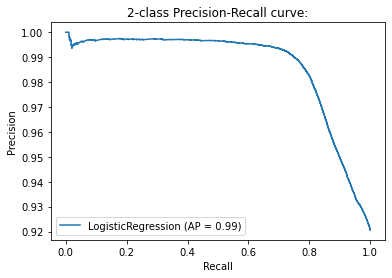

In [251]:
disp = plot_precision_recall_curve(LR_clf, X_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve:')

Text(0.5, 1.0, '2-class Precision-Recall curve:')

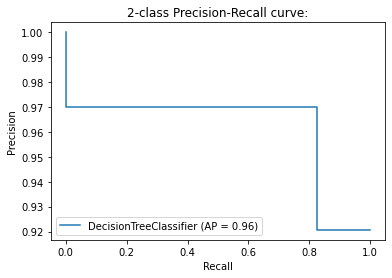

In [252]:
disp = plot_precision_recall_curve(DT_clf, X_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve:')

In [188]:
disp = plot_precision_recall_curve(XGB_clf, X_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve:')

ValueError: feature_names mismatch: ['School Metro Type_unknown', 'Project Cost', 'Project Grade Level Category_unknown', 'Project Grade Level Category_Grades 6-8', 'Number of dates since posted', 'Teacher Prefix_Ms.', 'School Metro Type_town', 'Teacher Prefix_Mrs.', 'School Metro Type_urban', 'Project Grade Level Category_Grades 9-12', 'School Metro Type_suburban', 'Teacher Prefix_Teacher', 'Teacher Prefix_Mr.', 'Teacher Prefix_Mx.', 'School Percentage Free Lunch', 'Project Grade Level Category_Grades PreK-2'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15']
expected School Metro Type_unknown, Project Cost, Project Grade Level Category_unknown, Project Grade Level Category_Grades 6-8, Number of dates since posted, Teacher Prefix_Ms., School Metro Type_town, Teacher Prefix_Mrs., School Metro Type_urban, Project Grade Level Category_Grades 9-12, School Metro Type_suburban, Teacher Prefix_Teacher, Teacher Prefix_Mr., Teacher Prefix_Mx., School Percentage Free Lunch, Project Grade Level Category_Grades PreK-2 in input data
training data did not have the following fields: f9, f13, f3, f14, f5, f6, f10, f2, f11, f15, f4, f1, f7, f12, f0, f8

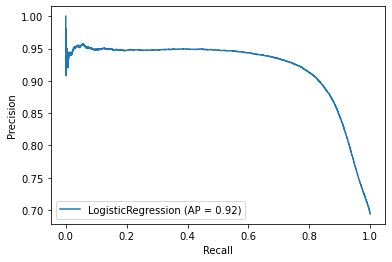

In [253]:
disp = plot_precision_recall_curve(clf, X_train, Y_train)

In [190]:
T100.head(20)

,Project Expiration Date,Project Cost,Number of dates since posted,Last Donation Received Date,Project Posted Date,Donation Amount,School Percentage Free Lunch,Fund_Ratio_30,School Metro Type_suburban,School Metro Type_town,...,Teacher Prefix_Ms.,Teacher Prefix_Mx.,Teacher Prefix_Teacher,Project Grade Level Category_Grades 6-8,Project Grade Level Category_Grades 9-12,Project Grade Level Category_Grades PreK-2,Project Grade Level Category_unknown,Label,Y_pred_test_prob,Y_pred_test
Project ID,,,,,,,,,,,,,,,,,,,,,
f664a4b580615ec134362beea4a7db81,2018-07-28,27972.85,0.833241,2018-03-28 19:59:52,2018-03-28,1.0,89.0,0.000036,0,0,...,1,0,0,1,0,0,0,1,1.0,1
3a1e9357a163fae01911b1628f4692fa,2018-08-02,44648.42,0.000000,2018-04-09 00:00:00,2018-04-09,0.0,56.0,0.000000,1,0,...,0,0,0,0,0,0,0,1,1.0,1
32f81e7617aeda8bddeb6db9c3979f43,2018-08-05,24961.42,0.000000,2018-04-18 00:00:00,2018-04-18,0.0,54.0,0.000000,0,0,...,0,0,0,0,1,0,0,1,1.0,1
b8743e15586241a71ed4708c5ca76eb3,2018-08-03,66454.25,0.000000,2018-04-09 00:00:00,2018-04-09,0.0,88.0,0.000000,0,0,...,1,0,0,0,1,0,0,1,1.0,1
5f1e1195575ab5e4afb3a3757e675d3c,2018-08-13,19091.74,0.000000,2018-04-20 00:00:00,2018-04-20,0.0,73.0,0.000000,0,0,...,0,0,0,1,0,0,0,1,1.0,1
45e4a6adba2c26ad63799c5afac16a8f,2018-07-28,16385.15,0.000000,2018-03-30 00:00:00,2018-03-30,0.0,91.0,0.000000,1,0,...,0,0,0,0,0,1,0,1,1.0,1
46bd4fa1d63f612d728774f7e41ef020,2018-07-19,16484.86,0.414306,2018-03-26 09:56:36,2018-03-26,25.0,67.0,0.001517,1,0,...,1,0,0,0,0,0,0,1,1.0,1
025761e7b80c3888cb2d37739c82f48b,2018-07-28,15808.40,0.000000,2018-04-16 00:00:00,2018-04-16,0.0,70.0,0.000000,0,0,...,0,0,0,0,0,1,0,1,1.0,1
58ff79f263604bf63a3d4e664eb80f69,2018-08-09,15630.11,0.000000,2018-04-10 00:00:00,2018-04-10,0.0,82.0,0.000000,1,0,...,0,0,0,0,1,0,0,1,1.0,1


In [255]:
plt.plot(T,LR_accT)
plt.show()
plt.plot(T,LR_acc)
plt.show()

NameError: name 'LR_accT' is not defined

ValueError: x and y must have same first dimension, but have shapes (132,) and (66,)

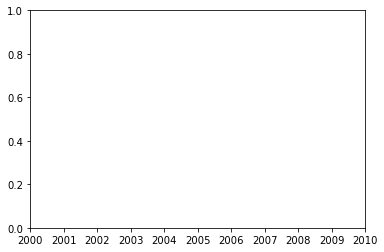

In [256]:
plt.plot(T,DT_accT)
plt.show()
plt.plot(T,DT_acc)
plt.show()

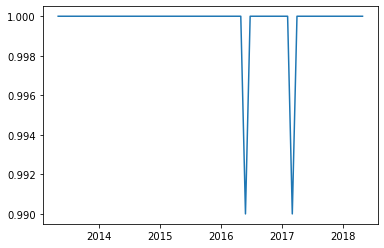

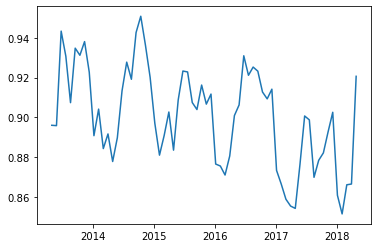

In [193]:
plt.plot(T,XGB_accT)
plt.show()
plt.plot(T,XGB_acc)
plt.show()

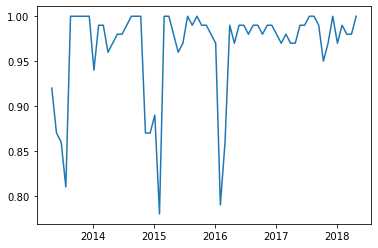

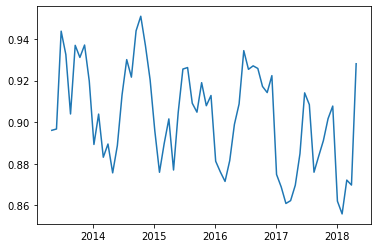

In [194]:
plt.plot(T,prT)
plt.show()
plt.plot(T,pr)

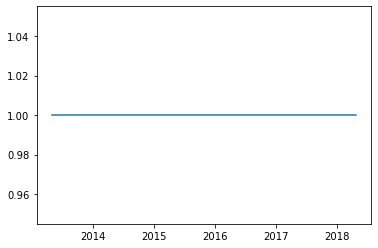

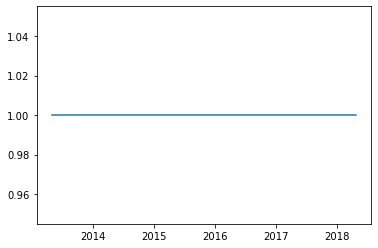

In [195]:
plt.plot(T,DT_prT)
plt.show()
plt.plot(T,DT_pr)

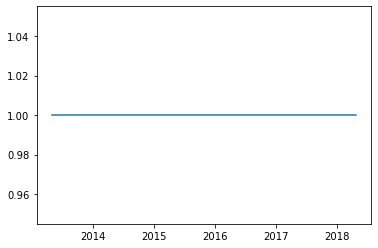

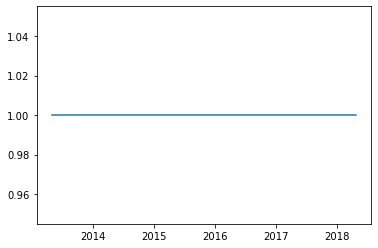

In [196]:
plt.plot(T,XGB_prT)
plt.show()
plt.plot(T,XGB_pr)

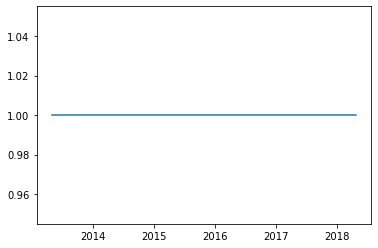

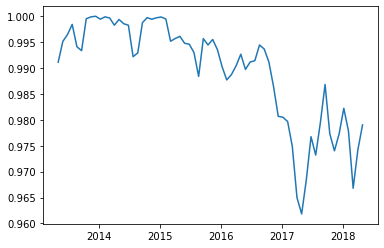

In [197]:
plt.plot(T,reT)
plt.show()
plt.plot(T,re)
plt.show()

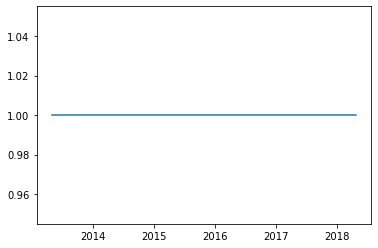

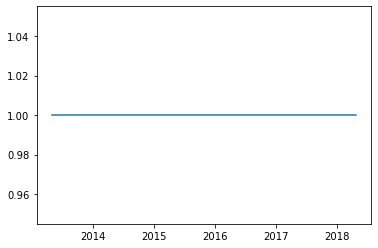

In [198]:
plt.plot(T,DT_reT)
plt.show()
plt.plot(T,DT_re)
plt.show()

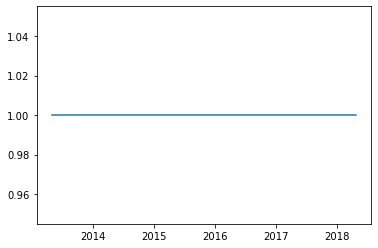

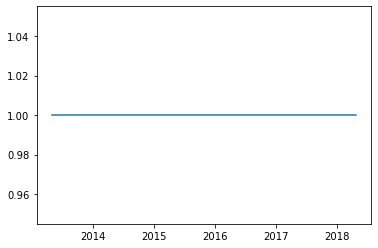

In [199]:
plt.plot(T,XGB_reT)
plt.show()
plt.plot(T,XGB_re)
plt.show()

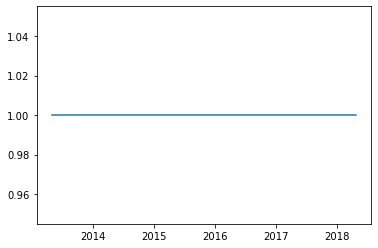

In [200]:
plt.plot(T,reT)
plt.show()

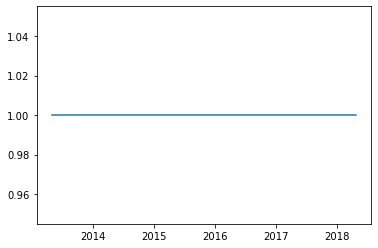

In [201]:
plt.plot(T,DT_reT)
plt.show()

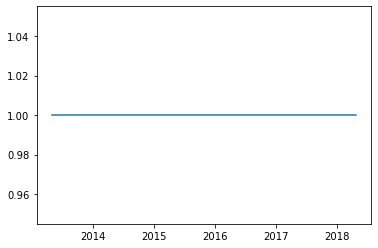

In [202]:
plt.plot(T,XGB_reT)
plt.show()

In [ ]:
print("As of Date:",T_current)
# X_train = Train_Data_Final.loc[:,Model_variables]
# X_train.head()
# Y_train =  Train_Data_Final.loc[:,["Label"]]
# Y_train

# X_test = Test_Data_Final.loc[:,Model_variables]
# X_test.head()
# Y_test =  Test_Data_Final.loc[:,["Label"]]
# Y_test

from pandas import DataFrame
import seaborn as sn
highCo=["Label"]+Model_variables
df = DataFrame(C_Data,columns=highCo)
fig, ax = plt.subplots(figsize=(15,10),sharex=True, sharey=True) 
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True,annot_kws={"size": 15},ax=ax)
highCo

In [214]:
Y_test=Test_Data_Final["Label"]

In [215]:

X_test=Test_Data_Final.loc[:,Model_variables]
X_test

,School Metro Type_unknown,Project Cost,Project Grade Level Category_unknown,Project Grade Level Category_Grades 6-8,Number of dates since posted,Teacher Prefix_Ms.,School Metro Type_town,Teacher Prefix_Mrs.,School Metro Type_urban,Project Grade Level Category_Grades 9-12,School Metro Type_suburban,Teacher Prefix_Teacher,Teacher Prefix_Mr.,Teacher Prefix_Mx.,School Percentage Free Lunch,Project Grade Level Category_Grades PreK-2
Project ID,,,,,,,,,,,,,,,,
f664a4b580615ec134362beea4a7db81,0,27972.85,0,1,0.833241,1,0,0,1,0,0,0,0,0,89.0,0
3a1e9357a163fae01911b1628f4692fa,0,44648.42,0,0,0.000000,0,0,0,0,0,1,0,1,0,56.0,0
32f81e7617aeda8bddeb6db9c3979f43,0,24961.42,0,0,0.000000,0,0,0,1,1,0,0,1,0,54.0,0
b8743e15586241a71ed4708c5ca76eb3,0,66454.25,0,0,0.000000,1,0,0,1,1,0,0,0,0,88.0,0
5f1e1195575ab5e4afb3a3757e675d3c,0,19091.74,0,1,0.000000,0,0,1,1,0,0,0,0,0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7b5156f38990963332b33298c8bae25e,0,183.14,0,1,2.863218,1,0,0,0,0,0,0,0,0,33.0,0
a95af5d07a16b350c6692228590df8e4,0,252.55,0,0,2.983981,0,0,1,1,1,0,0,0,0,13.0,0
11a7fef52a4f8e4d49db5857c6828fc0,0,410.20,0,0,2.997813,1,0,0,1,0,0,0,0,0,6.0,0


In [240]:
Y_pred_test_DT = DT_clf.predict(X_test)
Y_pred_test_DT_prob=DT_clf.predict_proba(X_test)

In [241]:
Y_pred_test_LR = LR_clf.predict(X_test)
Y_pred_test_LR_prob=LR_clf.predict_proba(X_test)

In [242]:
LR_clf

LogisticRegression(random_state=9)

In [243]:
DT_clf

DecisionTreeClassifier()

In [244]:
Test_Data_Final["Y_pred_test_LR"]=Y_pred_test_LR
Test_Data_Final["Y_pred_test_LR_prob"]=Y_pred_test_LR_prob[:,1]
Test_Data_Final["Y_pred_test_DT"]=Y_pred_test_DT
Test_Data_Final["Y_pred_test_DT_prob"]=Y_pred_test_DT_prob[:,1]

In [245]:
Test_Data_Final.to_csv("Test_Data_Final_LR_DT.csv")